In [1]:
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf


In [8]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [10]:
train=pd.read_csv('/content/drive/MyDrive/Corona_NLP_test.csv')
train.head()

UserName  ...           Sentiment
0         1  ...  Extremely Negative
1         2  ...            Positive
2         3  ...  Extremely Positive
3         4  ...            Negative
4         5  ...             Neutral

[5 rows x 6 columns]

In [11]:
print(train)

      UserName  ...           Sentiment
0            1  ...  Extremely Negative
1            2  ...            Positive
2            3  ...  Extremely Positive
3            4  ...            Negative
4            5  ...             Neutral
...        ...  ...                 ...
3793      3794  ...            Positive
3794      3795  ...            Negative
3795      3796  ...             Neutral
3796      3797  ...  Extremely Negative
3797      3798  ...  Extremely Positive

[3798 rows x 6 columns]


In [12]:
test=pd.read_csv('/content/drive/MyDrive/Corona_NLP_test.csv')
test.head()

UserName  ...           Sentiment
0         1  ...  Extremely Negative
1         2  ...            Positive
2         3  ...  Extremely Positive
3         4  ...            Negative
4         5  ...             Neutral

[5 rows x 6 columns]

In [13]:
train.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [14]:
train['Sentiment'].unique()

array(['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative',
       'Neutral'], dtype=object)

In [15]:
res=train['Sentiment'].value_counts(normalize=True)
res


Negative              0.274092
Positive              0.249342
Neutral               0.162981
Extremely Positive    0.157715
Extremely Negative    0.155872
Name: Sentiment, dtype: float64

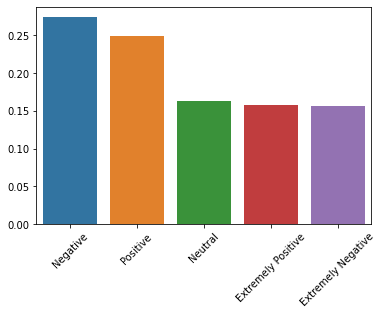

In [16]:
ax=sns.barplot(x=res.index,y=res.values)
plt.xticks(rotation=45)
plt.show()

In [17]:
! pip install Unidecode
! pip install wordninja

     |████████████████████████████████| 235 kB 5.2 MB/s 
     |████████████████████████████████| 541 kB 5.4 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=fe0534a324207fab13455a897f581821792c6258e64aebb81d5d69dd11d59988
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja


In [18]:
import re
import unidecode
import wordninja
import nltk
import string

In [19]:
def clean_text(text):
  # lower-case all characters
    text=text.lower()
    # remove twitter handles
    text= re.sub(r'@\S+', '',text) 
    # remove urls
    text= re.sub(r'http\S+', '',text) 
    text= re.sub(r'pic.\S+', '',text) 
    # replace unidecode characters
    text=unidecode.unidecode(text) 
    # regex only keeps characters
    text= re.sub(r"[^a-zA-Z+']", ' ',text)
    # keep words with length>1 only
    text=re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ') 
    text="".join([i for i in text if i not in string.punctuation])
    words=nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text =" ".join([i for i in words if i not in stopwords and len(i)>2])
    # split words like 'whatisthis' to 'what is this'
    def preprocess_wordninja(sentence):      
        def split_words(x):
            x=wordninja.split(x)
            x= [word for word in x if len(word)>1]
            return x
        new_sentence=[ ' '.join(split_words(word)) for word in sentence.split() ]
        return ' '.join(new_sentence)
    text=preprocess_wordninja(text)
    # regex removes repeated spaces, strip removes leading and trailing spaces
    text= re.sub("\s[\s]+", " ",text).strip()  
    return text

In [24]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
train.iloc[1]['OriginalTweet']

"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY"

In [30]:
train["OriginalTweet"]=train["OriginalTweet"].apply(clean_text)

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
test["OriginalTweet"]=test["OriginalTweet"].apply(clean_text)

In [32]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

In [33]:
train['Sentiment']=train['Sentiment'].apply(lambda x:change_sen(x))
test['Sentiment']=test['Sentiment'].apply(lambda x:change_sen(x))

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
le=LabelEncoder()
train['Sentiment']=le.fit_transform(train['Sentiment'])

In [36]:
test['Sentiment']=le.fit_transform(test['Sentiment'])

In [37]:
train['Sentiment'].nunique()

3

In [38]:
X_train = train['OriginalTweet']
y_train=train["Sentiment"]

In [39]:
X_test = test['OriginalTweet']
y_test=test["Sentiment"]

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding,LSTM
from tensorflow.keras.models import Model

convert sentences to sequences

In [41]:
MAX_VOCAB_SIZE = 30000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
# sequences_valid = tokenizer.texts_to_sequences(X_valid)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [42]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 9291 unique tokens.


In [43]:
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3798, 58)


In [44]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (3798, 58)


Create a  model

In [45]:
# We get to choose embedding dimensionality
D = 16

# Hidden state dimensionality
M = 32

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64,activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model = Model(i, x)

In [46]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  y_train,
  epochs=3,
  validation_data=(data_test, y_test)
)

Training model...
Epoch 1/3
119/119 [==============================] - 7s 38ms/step - loss: 1.0313 - accuracy: 0.4189 - val_loss: 0.9865 - val_accuracy: 0.4329
Epoch 2/3
119/119 [==============================] - 4s 33ms/step - loss: 0.9355 - accuracy: 0.4850 - val_loss: 0.8298 - val_accuracy: 0.5240
Epoch 3/3
119/119 [==============================] - 4s 34ms/step - loss: 0.6666 - accuracy: 0.7146 - val_loss: 0.4242 - val_accuracy: 0.8518


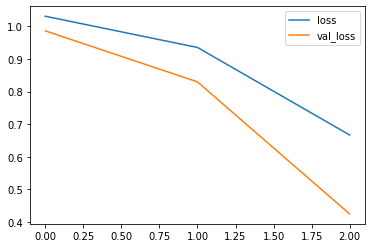

In [47]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

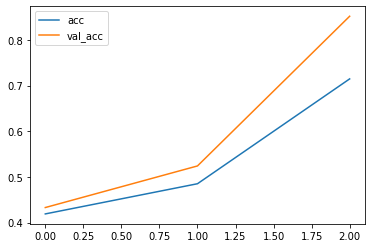

In [48]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [49]:
model.evaluate(data_train, y_train)

119/119 [==============================] - 1s 7ms/step - loss: 0.4242 - accuracy: 0.8518


[0.4242044687271118, 0.8517640829086304]

In [50]:
model.evaluate(data_test,y_test)

119/119 [==============================] - 1s 7ms/step - loss: 0.4242 - accuracy: 0.8518


[0.4242044687271118, 0.8517640829086304]

In [51]:
predictions= model.predict(data_test)

In [52]:
predictions[:10]

array([[0.8227017 , 0.02320246, 0.15409586],
       [0.04135303, 0.00205312, 0.9565939 ],
       [0.21547465, 0.16135292, 0.6231724 ],
       [0.22570153, 0.00285239, 0.7714461 ],
       [0.27727205, 0.6167791 , 0.1059488 ],
       [0.19091971, 0.7209019 , 0.08817834],
       [0.1332661 , 0.03544705, 0.83128685],
       [0.609669  , 0.11774428, 0.2725867 ],
       [0.04797516, 0.00098707, 0.9510378 ],
       [0.38795778, 0.01331094, 0.5987313 ]], dtype=float32)